In [1]:
import os
import numpy as np
import torch
from segment_anything import sam_model_registry
from segment_anything import SamPredictor
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
import utils.utils
import json
# This is the path for sam_vit_b.pth.
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = "/home/xionjing/segment-anything/model_checkpoint/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=ckpt).to(device)
sam_pred = SamPredictor(sam)
# This is my trained YoloV8 model best.pt
model_path = "/home/xionjing/CyroEM_segment/best.pt"
model = YOLO(model_path)
# The path to the patched picture for segmentation
one_patch_path = "/home/xionjing/CyroEM_segment/Cocodataset/train/images/T39_Rd2_FAP_Arm_A_16-5-3-5_73000x_0_3072.png"

# Provide segmentation for a patch

In [ ]:
history = model.predict(one_patch_path)

In [ ]:
boxes = format_boxesxyxy(history[0].boxes[4])
print(boxes)
box = torch.from_numpy(np.asarray(boxes[0]['bbox']))
image_pil = Image.open(one_patch_path).convert("RGB")
mask = utils.utils.predict_sam(sam = sam_pred, image_pil = image_pil, boxes = box, device = device)
image = utils.utils.draw_image(np.asarray(image_pil), mask.reshape([512,512]), box.reshape([1,4]))
image = Image.fromarray(np.uint8(image)).convert("RGB")
print(boxes)
image

# Code used to process the bounding box

In [2]:
bbox_json = "/home/xionjing/CyroEM_segment/Mask_working/bbox_result.json"
bbox_json_processed = "/home/xionjing/CyroEM_segment/Mask_working/bbox_result_processed.json"

if not os.path.exists(bbox_json_processed):
    with open(bbox_json, "r") as f:
        data = json.load(f)
        
    results_dict = utils.utils.remove_overlapping_boxes(data["bbox"], iou_threshold=0.3, overlap_small_threshold = 0.35)
    with open(bbox_json_processed, "w") as f:
        json.dump(results_dict, f)  

with open(bbox_json, "r") as f:
        data = json.load(f)
with open(bbox_json_processed, "r") as f:
    results_dict = json.load(f)
results = {"image_and_path": data["image_and_path"], "bbox": results_dict}

# OK, now let's provide segmentation for a whole picture

Suppose you have run the YoloV8_eval first 3 steps.

Visualize how many bboxes.

In [3]:
image_name = results["image_and_path"][3][0]
len(results["bbox"][image_name])
#utils.utils.draw_bbox(results["image_and_path"][0][0],results["image_and_path"][0][1],data["bbox"])

179

Now obtain the mask by the given bounding boxes for each picture
We tried to include as much boxes as possible in one 1024*1024 patch to speed up.

YOLOSAM performance benchmark:

100 pictures, 5 minutes to get all bboxes from Yolo. (3 second per picture)

20 seconds per picture to get all segmentation from SAM given the bounding boxes.

---

Test code of obtaining segmentation

In [10]:
import time
import matplotlib.pyplot as plt
annotation = {}
start = time.time()
i=78
def sort_regions(regions):
    return sorted(regions, key=lambda r: ((r['bbox'][1] + r['bbox'][3] // 2), (r['bbox'][0] + r['bbox'][2] // 2)))

for origin_image_path, patch_folder_path in results["image_and_path"][i:i+1]:
    start1 = time.time()
    image_name = origin_image_path
    img = Image.open(origin_image_path).convert('RGB')
    # Make sure the image was successfully loaded
    if img is None:
        print(f'Failed to load image: {image_name}')
        continue

    annotations = []
    print(len(results["bbox"][image_name]))
    
    # Create list of regions sorted by their center
    regions = sort_regions(results["bbox"][image_name])

    annotation[origin_image_path] = {"bbox":
                      {0: [],
                       1: [], 
                       2: []} ,
                                     "segment": 
                      {0: torch.zeros((4096, 4096)).cpu().numpy(),
                       1: torch.zeros((4096, 4096)).cpu().numpy(), 
                       2: torch.zeros((4096, 4096)).cpu().numpy()}}
    
    # Loop over all regions (bounding boxes) from top-left to bottom-right
    while len(regions) > 0:
        region = regions.pop(0)
        shape_attr = region["bbox"]
        region_class = region["class"]
        
        # Calculate the center of the box
        x_center = shape_attr[0] + shape_attr[2] // 2
        y_center = shape_attr[1] + shape_attr[3] // 2

        # Segment a 1024x1024 image that includes the bounding box
        xmin_segment = max(0, min(x_center - 1024 // 2, 4096 - 1024))
        ymin_segment = max(0, min(y_center - 1024 // 2, 4096 - 1024))
        xmax_segment = xmin_segment + 1024
        ymax_segment = ymin_segment + 1024
        image_1024 = img.crop((xmin_segment,ymin_segment, xmax_segment,  ymax_segment))
        # Other regions in the same patch
        same_patch_regions = []

        
        # Loop over remaining regions to find those in the same patch
        for other_region in regions:
            # Check if the center of other_region is within the same 1024x1024 patch as region
            # If yes, add it to same_patch_regions and remove it from regions
            if other_region['bbox'][0] >= xmin_segment + 64 and other_region['bbox'][1] >= ymin_segment + 64 and \
               other_region['bbox'][0] + other_region['bbox'][2] <= xmax_segment - 64 and \
               other_region['bbox'][1] + other_region['bbox'][3] <= ymax_segment - 64:
                same_patch_regions.append(other_region)
                regions.remove(other_region)
        
        
        # gather the bboxes for each class in that patch
        class_shapes = {0: [], 1: [], 2: []}
        for r in same_patch_regions:
            class_shapes[r["class"]].append(r["bbox"])
        class_shapes[region["class"]].append(region["bbox"])
        # Now you have a dictionary where each class maps to a list of shape_attr values

        # Dictionary to store masks for each class
        class_masks = {0: torch.zeros((4096, 4096)).cpu().numpy(),
                       1: torch.zeros((4096, 4096)).cpu().numpy(), 
                       2: torch.zeros((4096, 4096)).cpu().numpy()}
        
        # Process shape_attr for each class
        for class_id, shapes in class_shapes.items():
            # List to store boxes in 1024 size
            boxes_1024 = []
            
            for shape_attr in shapes:
                # Bounding box in xyxy format: [xmin, ymin, xmax, ymax]
                box = utils.utils.xywh_to_xyxy(shape_attr)
                # Convert the original box to the coordinate system of the 1024x1024 image
                box_1024 = [box[0] - xmin_segment, box[1] - ymin_segment, box[2] - xmin_segment, box[3] - ymin_segment]
                boxes_1024.append(box_1024)
            
            # Need at least have 1 bbox
            if len(boxes_1024)>=1:
                # Reshape boxes and send to the SAM model
                boxes_1024 = torch.tensor(boxes_1024).to(device)
                mask_1024 = utils.utils.predict_sam(sam=sam_pred, 
                      image_pil=image_1024, boxes=boxes_1024, device=device).transpose(2,3)#.flip(-1)
                # Now convert the 1024x1024 mask back to the original 4096x4096 size
                combined_mask = (mask_1024.sum(dim=0)> 0)
                class_masks[class_id][ymin_segment:ymax_segment, 
                   xmin_segment:xmax_segment] = combined_mask[0,:,:].transpose(0,1).cpu().numpy()
        
        
        # Append this annotation to the list
        for class_id, shapes in class_shapes.items():
            annotation[origin_image_path]["bbox"][class_id] += shapes
        for class_id, mask in class_masks.items():
            res = annotation[origin_image_path]["segment"][class_id] + mask
            annotation[origin_image_path]["segment"][class_id] = (res>0)
            if class_id == 0:
                pass
                #plt.imshow(mask, cmap='gray')
                #plt.show()
                #plt.imshow(annotation[origin_image_path]["segment"][class_id], cmap='gray')
                #plt.show()
            
    print(time.time()-start1)
    
"""
import pickle
segment_res = "/home/xionjing/CyroEM_segment/Mask_working/segment_result_with_strat.pkl"
with open(segment_res, 'wb') as file:
    pickle.dump(annotation, file)
"""
print("Used time:" )
print(time.time()-start)

92
51.8172504901886
Used time:
51.819981813430786


Without multiple box: 52 seconds
With multiple box: 25 seconds, but quiality may drop a little.

Total time: without multibox Used time: 
6472s
with multibox Used time: 2646s


annotation -> origin_image_path -> "bbox" / "segment" -> {0: [], 1: [], 2: []}

Test code of drawing segmentation

In [4]:
def draw_mask_annotations(img, annotation, segment = True):
    # define color for each class (red, green, blue)
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
    bbox_dict = annotation["bbox"]
    mask_dict = annotation["segment"]

    # Iterate over each class
    for class_type in [0,1,2]:
        # Iterate over each annotation of the class
        if len(bbox_dict[class_type]) > 0:
            for bbox in bbox_dict[class_type]:
                # Convert bbox from xywh to xyxy format
                bbox_xyxy = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]      
                # Draw the bounding box
                img = cv2.rectangle(img, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), colors[class_type], 2)

            if segment == True:
                mask_img = np.zeros_like(img)
                mask_img[mask_dict[class_type] == True] = colors[class_type]
                # Create alpha mask
                alpha_mask = np.zeros_like(img, dtype=np.uint8)
                alpha_mask[mask_dict[class_type] == True] = 255
                # Alpha composite mask_img and img
                foreground = cv2.bitwise_and(mask_img, alpha_mask)
                background = cv2.bitwise_and(img, cv2.bitwise_not(alpha_mask))
                img = cv2.add(foreground, background)

    return img

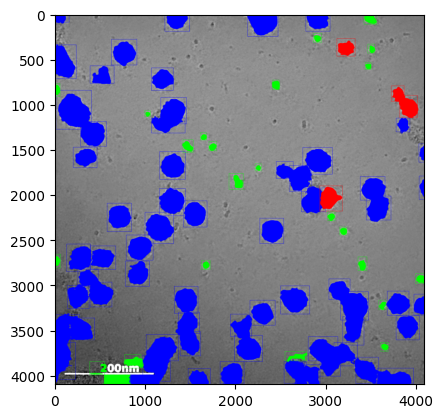

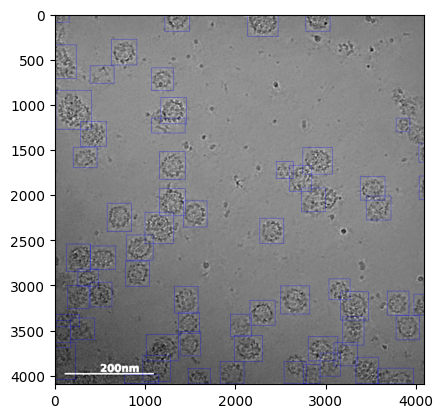

In [11]:
origin_image_path = results["image_and_path"][i][0]
img = cv2.imread(origin_image_path)
img_annotated_with = draw_mask_annotations(img, annotation[origin_image_path], segment = True)
plt.imshow(img_annotated_with)
plt.show()
plt.imshow(img)
plt.show()

# Now generate the pictures for the 512 size mask

In [22]:
def draw_mask_annotations_512(img, annotation, segment = True, num_colors = 30):
    # define color for each class (blue, green, red)
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)] # colors for bounding box
    
    
    bbox_dict = annotation["bbox"]
    mask_list = annotation["segment"]

    # Iterate over each class
    for class_type in [0,1,2]:
        # Iterate over each annotation of the class
        if len(bbox_dict[class_type]) > 0:
            for bbox in bbox_dict[class_type]:
                # Convert bbox from xywh to xyxy format
                bbox_xyxy = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]      
                # Draw the bounding box
                img = cv2.rectangle(img, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), colors[class_type], 5)

    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    if segment == True:
        numbers = len(mask_list)
        num_categories = num_colors
        cmap = plt.get_cmap('tab20')
        colors1 = [cmap(i) for i in range(num_categories)]
        colors_255 = [(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors1]
        for index, mask_dict in enumerate(mask_list):
            mask_img = np.zeros_like(img)
            mask_img[mask_dict['mask'] == True] = colors_255[index % num_colors]
            # Create alpha mask
            alpha_mask = np.zeros_like(img, dtype=np.uint8)
            alpha_mask[mask_dict['mask'] == True] = 255
            # Alpha composite mask_img and img
            foreground = cv2.bitwise_and(mask_img, alpha_mask)
            background = cv2.bitwise_and(img, cv2.bitwise_not(alpha_mask))
            img = cv2.add(foreground, background)

    return img

### Annotation of the 512 size.

Annotation file: "/home/xionjing/CyroEM_segment/Mask_working/segment_result_512_all_mask.pkl"

Structure:

annotation {  "picture_path" : annotation_for_that_picture}

annotation_for_that_picture { "bbox": dict_bbox,   "segment": segment_list}

dict_bbox : {0: [[x,y,w,h],...], 1: [[x,y,w,h],...], 2: [[x,y,w,h],...]}  But bounding box is in 4096 scale.

0 is virus, 1 is ice, 2 is unsure.

segment_list: [ {"mask": 512 array, "class" : 0}]

In [25]:
import pickle
import json
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

bbox_json = "/home/xionjing/CyroEM_segment/Mask_working/bbox_result.json"
bbox_json_processed = "/home/xionjing/CyroEM_segment/Mask_working/bbox_result_processed.json"
with open(bbox_json, "r") as f:
        data = json.load(f)
with open(bbox_json_processed, "r") as f:
    results_dict = json.load(f)
results = {"image_and_path": data["image_and_path"], "bbox": results_dict}

segment_res_512 = "/home/xionjing/CyroEM_segment/Mask_working/segment_result_512_all_mask.pkl"

if os.path.exists(segment_res_512):
    with open(segment_res_512, 'rb') as file:
        annotation = pickle.load(file)

for i in range(len( results["image_and_path"])):
    
    origin_image_path = results["image_and_path"][i][0]
    img = cv2.imread(origin_image_path)
    img_annotated_512 = draw_mask_annotations_512(img, annotation[origin_image_path], segment = True)
    #plt.imshow(img_annotated_512)
    #plt.show()
    
    img_bbox = draw_mask_annotations_512(img, annotation[origin_image_path], segment = False)
    
    #plt.imshow(img_bbox)
    #plt.show()
    print(origin_image_path)
    
    # Get directory and filename
    dir_name = os.path.basename(os.path.dirname(origin_image_path))
    file_name = os.path.basename(origin_image_path)
    # Combine and replace spaces with underscores
    output_folder = "/home/xionjing/CyroEM_segment/Mask_working/Segment_result_512/" + (dir_name + "/" + file_name).replace(' ', '_').replace(".png","")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    cv2.imwrite(output_folder + "/" + "Segment.png", img_annotated_512)
    cv2.imwrite(output_folder + "/" + "bbox.png", img_bbox)


/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_3-5-3-3_28000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_3-5-5-3_28000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_1-3-9-4_73000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_11-4-2-4_73000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_12-6-2-2_28000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_3-5-4-2_73000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_1-3-17-2_73000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_1-3-9-4_28000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_1-3-11-2_73000x.png
/home/xionjing/CyroEM_segment/All pictures/T39_Rd2_FAP_Arm_D/T39 Rd2 FAP Arm D_3-5-4-4_28000x.png
/home/xionjing/C

Chatgpt prompt to help me write codes:

write a function that convert xywh box to xyxy

def xywh_to_xyxy(box):

---

Now I have a image 4096 by 4096 pixel:

image_pil = Image.open(origin_image_path).convert("RGB")

And also a bounding box in xyxy format:

box

I need you to:

1. segment a image size 1024 by 1024 that include the bounding box, and then record the related bounding box xyxy coordinate box_1024

2. Use predict_sam(sam = sam_pred, image_pil = image_1024, boxes = box_1024, device = device) 
(device and sam_pred has already been defined) It will return the mask shape 1,1,1024,1024 based on the image_1024.

3. Now convert the mask back to the original 4096 by 4096 image

---

(follow up)

In this code, it fails to consider the situation that the center of the bounding box can be too close to the border so 1024 patch will be outside of the picture.


---

(follow up)

But in the step:

Now convert the 1024x1024 mask back to the original 4096x4096 size

When the mask is close to the edge, it will not be generated at the correct place

---

Now I have a lot of annotations including:

        annotations.append({
            "type": region_class,  
            "bbox": [x, y, width, height],
            "prob": region_prob,
            "mask": mask_4096
        })      

type can be 0,1,2
mask is a 4096 by 4096 true or false list

img = cv2.imread(origin_image_path)
Is a 4096 by 4096 image.

Now I would like you to draw the bounding box and mask for those annotations.

---

(follow up)

With the mask it's all black. I want the unmasked to be transparant

---

        # obtain the mask for each bbox:
        # Bounding box in xyxy format: [xmin, ymin, xmax, ymax]
        box = utils.utils.xywh_to_xyxy(shape_attr)
        # Calculate the center of the box
        x_center = box[0] + (box[2] - box[0]) // 2
        y_center = box[1] + (box[3] - box[1]) // 2
        # Segment a 1024x1024 image that includes the bounding box
        xmin_segment = max(0, min(x_center - 1024 // 2, img.shape[0] - 1024))
        ymin_segment = max(0, min(y_center - 1024 // 2, img.shape[1] - 1024))
        xmax_segment = xmin_segment + 1024
        ymax_segment = ymin_segment + 1024
        
        image_pil = Image.open(origin_image_path).convert('RGB')
        image_1024 = image_pil.crop((xmin_segment, ymin_segment, xmax_segment, ymax_segment))
        
        # Convert the original box to the coordinate system of the 1024x1024 image
        
        box_1024 = [box[0] - xmin_segment, box[1] - ymin_segment, box[2] - xmin_segment, box[3] - ymin_segment]
        #print((xmin_segment, ymin_segment, xmax_segment, ymax_segment))
        #print(box_1024)
        # Use the SAM prediction model
        box_1024 = torch.tensor(box_1024).reshape([1,4]).to(device)
        sam = sam_model_registry["vit_b"](checkpoint=ckpt).to(device)
        sam_pred = SamPredictor(sam)
        
        mask_1024 = utils.utils.predict_sam(sam=sam_pred, image_pil=image_1024, boxes=box_1024, device=device).transpose(2,3)
        
        # Now convert the 1024x1024 mask back to the original 4096x4096 size
        mask_4096 = torch.zeros((1, 1, 4096, 4096))
        mask_4096[:, :, xmin_segment:xmax_segment, ymin_segment:ymax_segment] = mask_1024
        mask_4096 = mask_4096.reshape([4096, 4096]).transpose(0,1)

This part of code get shape such as [1920, 0, 122, 70] and obtain the mask based on that shape back to 4096*4096.

Now I would like you to modify it to input to the predictor sam function with

class 0, [shape,shape,shape....], class 1 [shape,shape,shape,...] class 2